In [1]:
## Create dataset of perturbed CIFAR10 under all domains
## In the following, a valid question (no pun intended) is: why have a validation set? The reason is that the models
## used to generate adv attacks were trained on the same split of training/validation which may affect the distributions
## of adversarial attacks produced from samples seen during training by the model or not (in the case of validation).
## WARNING
## WARNING
## WARNING: IF YOU MODIFIED THE SEED TO TRAIN THE MODEL, AND WANT TO RUN THIS CODE, BE MINDFUL OF THE AFOREMENTIONED.

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random
import json

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 100

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_to_tensor)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)




def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks



def generate_augmented_data_from_loader(model, data_loader, data_shape, batch_size, domains):
    adversarial_data = (torch.zeros(data_shape), torch.zeros(data_shape[0]))
    for i_loader, (data, label) in enumerate(data_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)


        with ctx_noparamgrad_and_eval(model):
            # Clean data is a domain.
            data_all_domains = {}
            for domain in domains:
                data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)

        
        # Compute index where current batch start and ends in the entire data
        idx_start = i_loader * batch_size
        idx_end = idx_start + len(data)
        for i_domains, domain in enumerate(domains):
            adversarial_data[0][idx_start:idx_end, i_domains, :, :, :] = data_all_domains[domain].cpu()
            adversarial_data[1][idx_start:idx_end] = label.cpu()


    return adversarial_data

def generate_augmented_data_from_loader_and_save(model, data_loader, data_shape, batch_size, domains, working_dir_of_save, data_filename):
    adversarial_data = generate_augmented_data_from_loader(model, data_loader, data_shape, batch_size, domains)
    if not os.path.exists(working_dir_of_save):
        os.mkdir(working_dir_of_save)
    torch.save(adversarial_data, working_dir_of_save + data_filename)
    del adversarial_data
    return











    









WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])







domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack']
skipped_domains_worst_case = ['CW_mod']


num_test_batches = len(test_loader)

num_domains = len(domains)

    
    
######################    
# test the model #
######################
model.eval()



for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    
    # Create tensors to be filled with perturbed data
    adversarial_data_train_shape = [num_train_samples, num_domains, 3, 32, 32]
    adversarial_data_valid_shape = [num_valid_samples, num_domains, 3, 32, 32]
    adversarial_data_test_shape = [len(test_data), num_domains, 3, 32, 32]



    model_name = model_filenames[model_num]
    # Where the adversarial data will be saved
    working_dir_of_save = "data/adversarial-cifar10/" + model_name + "/"


    adversarial_data_train = generate_augmented_data_from_loader_and_save(model, train_loader, adversarial_data_train_shape, batch_size_train_and_valid, domains, working_dir_of_save, "adversarial_data_train.pt")
    import resource
    print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
    adversarial_data_valid = generate_augmented_data_from_loader_and_save(model, valid_loader, adversarial_data_valid_shape, batch_size_train_and_valid, domains, working_dir_of_save, "adversarial_data_valid.pt")
    print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
    adversarial_data_test = generate_augmented_data_from_loader_and_save(model, test_loader, adversarial_data_test_shape, batch_size_test, domains, working_dir_of_save, "adversarial_data_test.pt")
    print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)



    # Save various metadata
    metadata = {}
    metadata["mapping_idx_to_transform"] = []
    for i, domain in enumerate(domains):
        metadata["mapping_idx_to_transform"].append(str(i) + ": "+ domain)
    metadata["model_used"] = model_name
    metadata["seed"] = seed
    with open(working_dir_of_save + "metadata.json", "w") as outfile:
        json.dump(metadata, outfile)
    








ModuleNotFoundError: No module named 'torchvision'

In [25]:
## Train domain classifier on perturbed data with a ViT. You'll need torch 1.13 here and for the eval.
##
## Original plan was to do it with a class conditional ResNet18 (note the new operation on last layer),
## see https://arxiv.org/abs/1802.05637 and https://arxiv.org/abs/2006.04621 (<- has a repo), but it actually
## is much worse than the pretrained ViT.
##
## Make sure to select attacks and classes you're interested in by modifying the training flags.


# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch


import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

# import advertorch.attacks as attacks
# from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
# from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

import argparse
from distutils.util import strtobool
from math import pi
import json

import pandas as pd
import seaborn as sbn

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Optional. Initial learning rate value, default=0.1.")
# argument_parser.add_argument("--wd", type=float, help="Optional. Weight decay value for the optimiser. Default: 5e-4 for CIFAR10, or past value from checkpoint if resuming.")
# argument_parser.add_argument("--output_suffix", type=str, help="Optional. Suffix for path where files should be created.")
# argument_parser.add_argument("--only_classes", type=lambda s: [float(x) for x in s.split(',')], help="Optional. Restrict analysis to specified CIFAR10 classes (by index in CIFAR10).")
# argument_parser.add_argument("--only_domains", type=lambda s: [float(x) for x in s.split(',')], help="Optional. Restrict analysis to specified domains (by domain indices, see metadata.json).")
# argument_parser.add_argument("--only_perturbation", type=lambda x: bool(strtobool(x)), help="Optional. Only consider added perturbation (subtract original image) in analysis.")
# argument_parser.add_argument("--standardise", type=lambda x: bool(strtobool(x)), help="Optional. Recommanded with --only_perturbation. Standardise data during preprocessing.")

# parsed_args = argument_parser.parse_args()

domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack']

class TrainingFlags():
    def __init__(self):
        self.wd = None
        self.lr_init = None
        # Only CIFAR10 classes to consider perturbating
        self.only_classes = [0.]
        # Only attacks/indices to consider in domains array
        self.only_domains = [3, 7]
        # Subtract unperturbed x from x_adv
        self.only_perturbation = True
        self.standardise = True
        # Standardise per image instead of per dataset
        self.instance_standardisation = True
        # Output of training defaults to path based on chosen training flags. This allows adding a suffing to path.
        self.output_suffix = ""
        # Heavily recommend not modifying this -- old class conditional ResNet was not working well and is untested since adding ViT/using torch 1.13 reqs.
        self.model_type = "ViT"
        
parsed_args = TrainingFlags()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 100











# Need to be in place to save memory
def preprocess_data(data_path, parsed_args=parsed_args):
    # Note: tensor_data in this function does not include original dataset label, which is in tensor_label
    tensor_data, tensor_label = torch.load(data_path)

    # Only consider the added perturbations as data, by subtracting the original sample from each adversarial example.
    # Assumes 0th dim is original unperturbed sample #, 1st dim corresponds to perturbation used.
    if parsed_args.only_perturbation is True:
        num_domains = tensor_data.shape[1]
        for i_domains in range(0, num_domains):
            tensor_data[:, i_domains] -= tensor_data[:, 0]

    # Only consider some perturbation domains if applicable
    if parsed_args.only_domains is not None:
        tensor_data = tensor_data[:, parsed_args.only_domains]

    # Only consider some CIFAR10 classes if applicable
    if parsed_args.only_classes is not None:
        indices = []
        for iter_x, x in enumerate(tensor_label):
            if x in parsed_args.only_classes:
                indices.append(iter_x)
        print(tensor_label.shape)
        tensor_label = tensor_label[indices]
        tensor_data = tensor_data[indices]

    # Standardise TODO ONLY USE TRAINING
    if parsed_args.standardise is not (None or False):
        # Get indices of tensor_data over which to standardise. If instance standardisation, we standardise per sample, not over dataset.
        # Index 0 corresponds to which original CIFAR10 data sample, index 2 to RGB channels.
        if parsed_args.instance_standardisation == True:
            standardisation_dimensions = [x for x in range(0, len(tensor_data.shape)) if x != 0 and x != 2]
        else:
            standardisation_dimensions = [x for x in range(0, len(tensor_data.shape)) if x != 2]
        means = tensor_data.mean(dim=standardisation_dimensions, keepdim=True)
        stds = tensor_data.std(dim=standardisation_dimensions, keepdim=True)
        tensor_data = (tensor_data - means) / stds

    print(tensor_data.shape, tensor_label.shape)
    return tensor_data, tensor_label




"""
ViT transforms
"""
# Resize the input images
resize_transform = transforms.Resize((224, 224))

# Define a transform to reshape the input data
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)







data_path = "data/adversarial-cifar10/model_PGD_Linf_103.pt/"

tensor_train_data = preprocess_data(data_path+"adversarial_data_train.pt", parsed_args)
train_data = CustomTensorDataset(tensor_train_data, transform=resize_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid, worker_init_fn=seed_init_fn)


# del train_data, train_loader
tensor_valid_data = preprocess_data(data_path+"adversarial_data_valid.pt", parsed_args)
valid_data = CustomTensorDataset(tensor_valid_data, transform=resize_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid, worker_init_fn=seed_init_fn)


with open(data_path + "metadata.json", 'r') as json_file:
    metadata = json.load(json_file)
# del valid_data, valid_loader
# test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)





class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ClassConditionalResNet(nn.Module):
    def __init__(self, block, num_blocks, num_output_classes=10, num_original_classes=10):
        super(ClassConditionalResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.class_conditional = torch.nn.utils.spectral_norm(nn.Embedding(num_original_classes, 512 * block.expansion))
        self.linear = nn.Linear(512 * block.expansion, num_output_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, y):
        features = F.relu(self.bn1(self.conv1(x)))
        features = self.layer1(features)
        features = self.layer2(features)
        features = self.layer3(features)
        features = self.layer4(features)
        features = F.avg_pool2d(features, 4)
        features = features.view(features.size(0), -1)
        out = self.linear(features)
        if y is not None:
            out += torch.sum(self.class_conditional(y) * features, dim=1, keepdim=True)
#         print(x.size(), out.size())
        return out

# Output classes are the classes the model can output (domains), original classes are the labels (e.g. CIFAR10 labels) of the unperturbed dataset
def ClassConditionalResNet18(num_output_classes=10, num_original_classes=10):
    return ClassConditionalResNet(BasicBlock, [2, 2, 2, 2], num_output_classes=num_output_classes, num_original_classes=num_original_classes)







def prepare_model(parsed_args, num_original_classes=10, num_output_classes=10, model_type="ViT"):
    if parsed_args.only_classes is None:
        if parsed_args.only_domains is None:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18()
        else:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_output_classes=len(parsed_args.only_domains))
    else:
        if parsed_args.only_domains is None:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes))
        else:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes), num_output_classes=len(parsed_args.only_domains))
    model.to(device)

    # if str(device) == "cuda" and torch.cuda.device_count() > 1:
    #     print("Using DataParallel")
    #     model = torch.nn.DataParallel(model)

    for param in model.parameters():
        param.requires_grad = False
    # Set output layers to out_features=num_output_classes since model is pretrained on ImageNet
    model.heads = torch.nn.Linear(in_features=768, out_features=len(parsed_args.only_domains), bias=True)
    return model









def prepare_data_for_attack_discriminator(data, label, num_domains, device=device):
    data, label = data.to(device), label.to(device).long()
    # Number of unperturbed samples in batch. Generally = batch_size except the last iter of epoch
    num_unperturbed_samples_batch = data.shape[0]
    # Reformats data so first axis is domain
    data = data.swapaxes(0,1)
    # Reformats data so data[:batch_size] is all the batch samples from the first domain, etc.
    data_stacked_domains_shape = [num_domains * num_unperturbed_samples_batch] + list(data.shape)[2:]
    data = data.reshape(data_stacked_domains_shape)
    domain_label = torch.LongTensor(range(0, num_domains))
    domain_label = (torch.transpose(domain_label.repeat(num_unperturbed_samples_batch,1), 0, 1)).flatten()
    domain_label = domain_label.to(device)
    label = label.repeat(num_domains)
    return data, label, domain_label














save_interval = 1
top_k = 3


if parsed_args.only_domains is not None:
    domains = [domains[int(i)] for i in parsed_args.only_domains]

num_domains = len(domains)
if num_domains < top_k:
    print("There are less domains than k for top_k accuracy, top_k set to num_domains")
    top_k = num_domains

model = prepare_model(parsed_args, model_type=parsed_args.model_type)
model.to(device)
# number of epochs to train the model
n_epochs_AIT = 1001
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
lr_init = 0.1
best_epoch = 0
starting_epoch = 0
# # the following var decides when we start waterfalling in the REx term (includes the chosen epoch)
# waterfall_epoch = 326
momentum = 0.9
if parsed_args.wd is not None:
    weight_decay = parsed_args.wd
else:
    weight_decay = 5e-4
# optimizer = torch.optim.SGD(model.parameters(), lr = lr_init, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters())
# schedule = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)


parsed_args_into_path = ""
if parsed_args.only_classes is not None:
    parsed_args_into_path += "classes_" + "-".join(str(int(s)) for s in parsed_args.only_classes)
if parsed_args.only_domains is not None:
    parsed_args_into_path += "domains_" + "-".join(str(int(s)) for s in parsed_args.only_domains)
if parsed_args.only_perturbation is True:
    parsed_args_into_path += "only_pert"
if parsed_args.standardise is True:
    if parsed_args.instance_standardisation is True:
        parsed_args_into_path += "instancestd"
    else:
        parsed_args_into_path += "std"
TRAINED_MODEL_PATH = "experiments/discriminate_attacks/" + data_path.split('/')[-2] + "/" + parsed_args.model_type + "/" + parsed_args_into_path + parsed_args.output_suffix + "_ERM/"

path_of_checkpoint = ""
writer = SummaryWriter(TRAINED_MODEL_PATH)











# MODIFY GIVEN PARSED ARGUMENTS
try:
    if parsed_args.lr_init is not None:
        lr_init = parsed_args.lr_init
        optimizer.param_groups[0]['lr'] = lr_init
        print("lr_init set to %f by user" % parsed_args.lr_init)
        
except:
    print("No learning rate passed as argument; using default/past value of ", lr_init)













# Parallelise model if possible
if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)








for epoch in range(starting_epoch, n_epochs_AIT):
    # Keep track of total (REx or ERM) losses
    train_loss = 0
    valid_loss = 0

    which_batch_train = 1
    num_training_batches_in_epoch = len(train_loader)
    which_batch_valid = 1
    num_validation_batches = len(valid_loader)


    topk_accuracies_train = torch.zeros(top_k)
    topk_accuracies_valid = torch.zeros(top_k)

    confusion_matrix_train = torch.zeros([num_domains, num_domains])
    confusion_matrix_valid = torch.zeros([num_domains, num_domains])


    ###################
    # Train the model #
    ###################
    model.train()
    for data, label in train_loader:
        data, label, domain_label = prepare_data_for_attack_discriminator(data, label, num_domains, device)

        optimizer.zero_grad()
        preds = model(data)#, y=label)
        loss = F.cross_entropy(preds, domain_label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        # Update count of number of correct predictions per domain
        with torch.no_grad():
            predicted_topk = torch.topk(preds, top_k, dim=1).indices
            for pred, target in zip(predicted_topk, domain_label):
                confusion_matrix_train[int(target), int(pred[0])] += 1
                for iter_topk in range(0, top_k):
                    if target in pred[:iter_topk+1]:
                        topk_accuracies_train[iter_topk] += 1

        which_batch_train += 1



    ######################    
    # Validate the model #
    ######################
    model.eval()
    for _, (data, label) in enumerate(valid_loader):
        data, label, domain_label = prepare_data_for_attack_discriminator(data, label, num_domains, device)

        with torch.no_grad():
            preds = model(data)#, y=label)
            loss = F.cross_entropy(preds, domain_label)
            valid_loss += loss.item() * data.size(0)
            
            # Update count of number of correct predictions per domain
            predicted_topk = torch.topk(preds, top_k, dim=1).indices
            for pred, target in zip(predicted_topk, domain_label):
                confusion_matrix_valid[int(target), int(pred[0])] += 1
                for iter_topk in range(0, top_k):
                    if target in pred[:iter_topk+1]:
                        topk_accuracies_valid[iter_topk] += 1

        which_batch_valid += 1



    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    training_acc = torch.sum(confusion_matrix_train.diagonal()) / (len(train_loader.sampler) * num_domains)
    valid_acc = torch.sum(confusion_matrix_valid.diagonal()) / (len(valid_loader.sampler) * num_domains)

    topk_accuracies_train /= (len(train_loader.sampler) * num_domains)
    topk_accuracies_valid /= (len(valid_loader.sampler) * num_domains)

    if training_acc != topk_accuracies_train[0]:
        print(training_acc)
        print(topk_accuracies_train)
        raise ValueError("Something's wrong with the topk acc.")

    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
        epoch+1, 
        train_loss,
        valid_loss
        ))


    for iter_topk in range(0, top_k):
        print("Top {} training accuracy: {:.6f} \tTop {} validation accuracy: {:.6f}".format(
            iter_topk+1,
            topk_accuracies_train[iter_topk],
            iter_topk+1,
            topk_accuracies_valid[iter_topk]
            ), flush=True)

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). '.format(
        valid_loss_min,
        valid_loss))
        best_epoch = epoch
        valid_loss_min = valid_loss
        
    path_of_checkpoint = TRAINED_MODEL_PATH + 'model_ERM_' + str(epoch+1) + '.pt'
    
    # epoch_lr = schedule.get_last_lr()[0]
    # schedule.step()
    # # lr to start from in checkpoint
    # lr_init = schedule.get_last_lr()[0]
    
    checkpoint = {'current_model': model.module.state_dict(),
                  'optimiser': optimizer.state_dict(),
                #   'schedule': schedule.state_dict(),
                  'learning_rate': lr_init,
                  'epoch': epoch + 1,
                  'best_epoch': best_epoch,
                  'seed': seed
                 }

    if (epoch+1) % save_interval == 0: #and epoch+1 >= 50:
        torch.save(checkpoint, path_of_checkpoint)
    
    # writer.add_scalar('Learning_rate', epoch_lr, epoch+1)
    writer.add_scalar('Momentum', momentum, epoch+1)
    writer.add_scalar('Weight_decay', weight_decay, epoch+1)

    writer.add_scalar('Training_loss', train_loss, epoch+1)
    writer.add_scalar('Validation_loss', valid_loss, epoch+1)

    writer.add_scalar('Training_accuracy', training_acc, epoch+1)
    writer.add_scalar('Validation_accuracy', valid_acc, epoch+1)

    # writer.


    
writer.close()


torch.Size([40000])
torch.Size([4014, 3, 3, 32, 32]) torch.Size([4014])
torch.Size([10000])
torch.Size([986, 3, 3, 32, 32]) torch.Size([986])
The user did not set --resume to True. Training from scratch...
Did not force a scheduler reset.
Using DataParallel
Epoch: 1 	Training Loss: 3.253968 	Validation Loss: 3.230947
Top 1 training accuracy: 0.395283 	Top 1 validation accuracy: 0.407032
Top 2 training accuracy: 0.735592 	Top 2 validation accuracy: 0.746450
Top 3 training accuracy: 1.000000 	Top 3 validation accuracy: 1.000000
Validation loss decreased (inf --> 3.230947). 
Epoch: 2 	Training Loss: 3.121182 	Validation Loss: 3.169043
Top 1 training accuracy: 0.450839 	Top 1 validation accuracy: 0.434415
Top 2 training accuracy: 0.785999 	Top 2 validation accuracy: 0.756592
Top 3 training accuracy: 1.000000 	Top 3 validation accuracy: 1.000000
Validation loss decreased (3.230947 --> 3.169043). 
Epoch: 3 	Training Loss: 3.061275 	Validation Loss: 3.138187
Top 1 training accuracy: 0.473260 

KeyboardInterrupt: 

In [ ]:
## Test domain classifier on perturbed data


# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 


import numpy as np
import torch


import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

# import advertorch.attacks as attacks
# from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
# from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

import argparse
from distutils.util import strtobool
from math import pi
import json

import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Optional. Initial learning rate value, default=0.1.")
# argument_parser.add_argument("--wd", type=float, help="Optional. Weight decay value for the optimiser. Default: 5e-4 for CIFAR10, or past value from checkpoint if resuming.")
# argument_parser.add_argument("--output_suffix", type=str, help="Optional. Suffix for path where files should be created.")
# argument_parser.add_argument("--only_classes", type=lambda s: [float(x) for x in s.split(',')], help="Optional. Restrict analysis to specified CIFAR10 classes (by index in CIFAR10).")
# argument_parser.add_argument("--only_domains", type=lambda s: [float(x) for x in s.split(',')], help="Optional. Restrict analysis to specified domains (by domain indices, see metadata.json).")
# argument_parser.add_argument("--only_perturbation", type=lambda x: bool(strtobool(x)), help="Optional. Only consider added perturbation (subtract original image) in analysis.")
# argument_parser.add_argument("--standardise", type=lambda x: bool(strtobool(x)), help="Optional. Recommanded with --only_perturbation. Standardise data during preprocessing.")

# parsed_args = argument_parser.parse_args()


class TrainingFlags():
    def __init__(self):
        # Only CIFAR10 classes to consider perturbating
        self.only_classes = [0.]
        # Only attacks/indices to consider in domains array
        self.only_domains = [3, 7]
        # Subtract unperturbed x from x_adv
        self.only_perturbation = True
        self.standardise = True
        # Standardise per image instead of per dataset
        self.instance_standardisation = True
parsed_args = TrainingFlags()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 100











# Need to be in place to save memory
def preprocess_data(data_path, parsed_args=parsed_args):
    # Note: tensor_data in this function does not include original dataset label, which is in tensor_label
    tensor_data, tensor_label = torch.load(data_path)

    # Only consider the added perturbations as data, by subtracting the original sample from each adversarial example.
    # Assumes 0th dim is original unperturbed sample #, 1st dim corresponds to perturbation used.
    if parsed_args.only_perturbation is True:
        num_domains = tensor_data.shape[1]
        for i_domains in range(0, num_domains):
            tensor_data[:, i_domains] -= tensor_data[:, 0]

    # Only consider some perturbation domains if applicable
    if parsed_args.only_domains is not None:
        tensor_data = tensor_data[:, parsed_args.only_domains]

    # Only consider some CIFAR10 classes if applicable
    if parsed_args.only_classes is not None:
        indices = []
        for iter_x, x in enumerate(tensor_label):
            if x in parsed_args.only_classes:
                indices.append(iter_x)
        print(tensor_label.shape)
        tensor_label = tensor_label[indices]
        tensor_data = tensor_data[indices]

    # Standardise TODO ONLY USE TRAINING
    if parsed_args.standardise is not (None or False):
        # Get indices of tensor_data over which to standardise. If instance standardisation, we standardise per sample, not over dataset.
        # Index 0 corresponds to which original CIFAR10 data sample, index 2 to RGB channels.
        if parsed_args.instance_standardisation == True:
            standardisation_dimensions = [x for x in range(0, len(tensor_data.shape)) if x != 0 and x != 2]
        else:
            standardisation_dimensions = [x for x in range(0, len(tensor_data.shape)) if x != 2]
        means = tensor_data.mean(dim=standardisation_dimensions, keepdim=True)
        stds = tensor_data.std(dim=standardisation_dimensions, keepdim=True)
        tensor_data = (tensor_data - means) / stds

    print(tensor_data.shape, tensor_label.shape)
    return tensor_data, tensor_label




"""
ViT transforms
"""
# Resize the input images
resize_transform = transforms.Resize((224, 224))

# Define a transform to reshape the input data
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)







data_path = "data/adversarial-cifar10/model_PGD_Linf_103.pt/"


tensor_test_data = preprocess_data(data_path+"adversarial_data_test.pt", parsed_args)
test_data = CustomTensorDataset(tensor_test_data, transform=resize_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


with open(data_path + "metadata.json", 'r') as json_file:
    metadata = json.load(json_file)







class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ClassConditionalResNet(nn.Module):
    def __init__(self, block, num_blocks, num_output_classes=10, num_original_classes=10):
        super(ClassConditionalResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.class_conditional = torch.nn.utils.spectral_norm(nn.Embedding(num_original_classes, 512 * block.expansion))
        self.linear = nn.Linear(512 * block.expansion, num_output_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, y):
        features = F.relu(self.bn1(self.conv1(x)))
        features = self.layer1(features)
        features = self.layer2(features)
        features = self.layer3(features)
        features = self.layer4(features)
        features = F.avg_pool2d(features, 4)
        features = features.view(features.size(0), -1)
        out = self.linear(features)
        if y is not None:
            out += torch.sum(self.class_conditional(y) * features, dim=1, keepdim=True)
#         print(x.size(), out.size())
        return out

# Output classes are the classes the model can output (domains), original classes are the labels (e.g. CIFAR10 labels) of the unperturbed dataset
def ClassConditionalResNet18(num_output_classes=10, num_original_classes=10):
    return ClassConditionalResNet(BasicBlock, [2, 2, 2, 2], num_output_classes=num_output_classes, num_original_classes=num_original_classes)

def prepare_model(parsed_args, num_original_classes=10, num_output_classes=10, model_type="ViT"):
    if parsed_args.only_classes is None:
        if parsed_args.only_domains is None:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18()
        else:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_output_classes=len(parsed_args.only_domains))
    else:
        if parsed_args.only_domains is None:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes))
        else:
            model = torchvision.models.vit_b_16(weights="IMAGENET1K_SWAG_LINEAR_V1")#ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes), num_output_classes=len(parsed_args.only_domains))
    model.to(device)

    # if str(device) == "cuda" and torch.cuda.device_count() > 1:
    #     print("Using DataParallel")
    #     model = torch.nn.DataParallel(model)

    for param in model.parameters():
        param.requires_grad = False
    # Set output layers to out_features=num_output_classes since model is pretrained on ImageNet
    model.heads = torch.nn.Linear(in_features=768, out_features=len(parsed_args.only_domains), bias=True)
    return model







# if parsed_args.only_classes is None:
#     if parsed_args.only_domains is None:
#         model = ClassConditionalResNet18()
#     else:
#         model = ClassConditionalResNet18(num_output_classes=len(parsed_args.only_domains))
# else:
#     if parsed_args.only_domains is None:
#         model = ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes))
#     else:
#         model = ClassConditionalResNet18(num_original_classes=len(parsed_args.only_classes), num_output_classes=len(parsed_args.only_domains))
# # model = ClassConditionalResNet18(num_original_classes=len(parsed_args.only_domains), num_output_classes=len(parsed_args.only_domains))
# model.to(device)

# if str(device) == "cuda" and torch.cuda.device_count() > 1:
#     print("Using DataParallel")
#     model = torch.nn.DataParallel(model)










def prepare_data_for_attack_discriminator(data, label, num_domains, device=device):
    data, label = data.to(device), label.to(device).long()
    # Number of unperturbed samples in batch. Generally = batch_size except the last iter of epoch
    num_unperturbed_samples_batch = data.shape[0]
    # Reformats data so first axis is domain
    data = data.swapaxes(0,1)
    # Reformats data so data[:batch_size] is all the batch samples from the first domain, etc.
    data_stacked_domains_shape = [num_domains * num_unperturbed_samples_batch] + list(data.shape)[2:]
    data = data.reshape(data_stacked_domains_shape)
    domain_label = torch.LongTensor(range(0, num_domains))
    domain_label = (torch.transpose(domain_label.repeat(num_unperturbed_samples_batch,1), 0, 1)).flatten()
    domain_label = domain_label.to(device)
    label = label.repeat(num_domains)
    return data, label, domain_label














top_k = 3
if len(parsed_args.only_domains) < 3:
    top_k = len(parsed_args.only_domains)


domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack']
domains_latex = [r"None", r"$P_1$", r"$P_2$", r"$P_\infty$", r"$\textit{DF}_\infty$", r"$\textit{CW}_2$",
                r"$P_\infty^\bullet$", r"$\textit{DF}_\infty^\bullet$", r"$\textit{CW}_2^\bullet$", r"$\textit{AA}_\infty$"]

if parsed_args.only_domains is not None:
    domains = [domains[int(i)] for i in parsed_args.only_domains]
    domains_latex = [domains_latex[int(i)] for i in parsed_args.only_domains]

num_domains = len(domains)
model = prepare_model(parsed_args)
model.to(device)

WORKING_DIR = "results/adversarial-cifar10/model_PGD_Linf_103.pt/ViT/"#classes_0domains_3-7only_pertinstancestd_ERM/"
if parsed_args.only_classes is not None:
    WORKING_DIR += "classes_" + "-".join(str(int(s)) for s in parsed_args.only_classes)
if parsed_args.only_domains is not None:
    WORKING_DIR += "domains_" + "-".join(str(int(s)) for s in parsed_args.only_domains)
if parsed_args.only_perturbation is True:
    WORKING_DIR += "only_pert"
if parsed_args.standardise is True:
    if parsed_args.instance_standardisation is True:
        WORKING_DIR += "instancestd"
    else:
        WORKING_DIR += "std"
WORKING_DIR += "_ERM/"

TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]



# adversarial-invariance/experiments/discriminate_attacks/model_PGD_Linf_103.pt/classes_0domains_1-2-3-4-5-6-7-8-9only_pertstd_ERM/model_ERM_127.pt




# Parallelise model if possible
if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)








for model_num, model_path in enumerate(model_paths):
    # Loading the PAT model is slightly different
    checkpoint = torch.load(model_path)
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")

    # Keep track of total (REx or ERM) losses
    test_loss = 0

    which_batch_test = 1
    num_test_batches = len(test_loader)

    topk_accuracies_test = torch.zeros(top_k)

    confusion_matrix_test = torch.zeros([num_domains, num_domains]).to(device)




    ######################    
    # Test the model #
    ######################
    model.eval()
    for _, (data, label) in enumerate(test_loader):
        data, label, domain_label = prepare_data_for_attack_discriminator(data, label, num_domains, device)

        with torch.no_grad():
            preds = model(data)#, y=label)
            loss = F.cross_entropy(preds, domain_label)
            test_loss += loss.item() * data.size(0)
            
            # Update count of number of correct predictions per domain
            # pred_probabilities = F.softmax(preds, dim=1)
            predicted_topk = torch.topk(preds, top_k, dim=1).indices
            for iter_samples, (pred, target) in enumerate(zip(predicted_topk, domain_label)):
                # confusion_matrix_test[int(target)] += pred_probabilities[iter_samples]
                confusion_matrix_test[int(target), int(pred[0])] += 1
                for iter_topk in range(0, top_k):
                    if target in pred[:iter_topk+1]:
                        topk_accuracies_test[iter_topk] += 1

        # which_batch_test += 1




    test_loss = test_loss / len(test_loader.sampler)
    test_acc = torch.sum(confusion_matrix_test.diagonal()) / (len(test_loader.sampler) * num_domains)
    topk_accuracies_test /= (len(test_loader.sampler) * num_domains)
    # shouldn't divide by num_domains as the confusion matrix is mostly read per column or row, in which
    # case the max expected number of samples should (but not quite for predicted labels) be len(test_loader.sampler)
    confusion_matrix_test /= len(test_loader.sampler)
    # if test_acc != topk_accuracies_test[0]:
    #     raise ValueError("The two ways of computing acc don't match !")


    print("Model: {} \tTest Loss: {:.6f}".format(
        model_filenames[model_num], 
        test_loss
        ))


    for iter_topk in range(0, top_k):
        print("Top {} test accuracy: {:.6f}".format(
            iter_topk+1,
            topk_accuracies_test[iter_topk]
            ), flush=True)

    confusion_matrix_test = confusion_matrix_test.cpu().numpy()
    results = {}
    results["topk_accuracies"] = topk_accuracies_test
    results["confusion_matrix"] = confusion_matrix_test


    plt.rcParams['text.usetex'] = True
    df_confmat = pd.DataFrame(confusion_matrix_test, index = domains_latex, columns=domains_latex)
    fig = plt.figure(figsize=(15,10))#, dpi=1200)
    # sbn.set(font_scale=3)
    # Recommended font sizes: [20, 24] for 9 attacks, [30, 36] for 5, [25, 30] for 3, [60, 72] for 2
    custom_fontsizes = [25, 30]
    heatmap = sbn.heatmap(df_confmat, annot=True, fmt=".2f", annot_kws={
                'fontsize': custom_fontsizes[0]})
    x_ticks_pos, _ = plt.xticks()
    heatmap.set_xticks(x_ticks_pos + 0.2)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=custom_fontsizes[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=custom_fontsizes[1])
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=custom_fontsizes[0])
    plt.ylabel('True label', fontsize=custom_fontsizes[1])
    plt.xlabel('Predicted label', fontsize=custom_fontsizes[1])

    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    np.save(working_dir_of_save + model_filenames[model_num], results)
    fig.savefig(working_dir_of_save + model_filenames[model_num] + "_confusion_matrix.pdf", bbox_inches='tight')
    plt.show()

    


In [3]:
## Current and subsequent cells: visualisation stuff for the custom adversarially perturbed CIFAR10 dataset.



import numpy as np
import torch


from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 100






data_path = "data/adversarial-cifar10/model_ERM_clean_56.pt/"
tensor_training_data = torch.load(data_path+"adversarial_data_train.pt")
train_data = torch.utils.data.TensorDataset(tensor_training_data[0], tensor_training_data[1])
num_train_samples = len(train_data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)


# del train_data, train_loader
# tensor_valid_data = torch.load(data_path+"adversarial_data_valid.pt")
# valid_data = torch.utils.data.TensorDataset(tensor_valid_data[0], tensor_valid_data[1])
# num_valid_samples = len(valid_data)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)

for _, (data, label) in enumerate(train_loader):
    data, label = data.to(device), label.to(device)
    print(data.shape)
    print(label.shape)
    break

torch.Size([128, 10, 3, 32, 32])
torch.Size([128])


torch.Size([40000])
torch.Size([4014, 5, 3, 32, 32]) torch.Size([4014])
torch.Size([10000])
torch.Size([986, 5, 3, 32, 32]) torch.Size([986])
tensor([0.])
torch.Size([986, 1, 3, 1, 1])


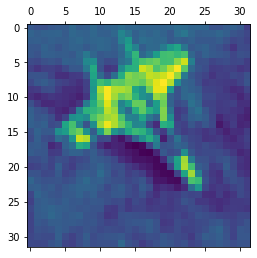

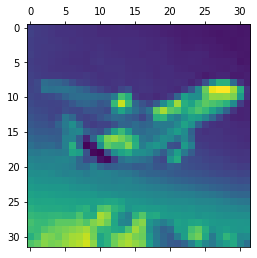

In [6]:
import matplotlib.pyplot as plt


tensor_training_data = preprocess_data(data_path+"adversarial_data_train.pt", parsed_args)


# del train_data, train_loader
tensor_valid_data = preprocess_data(data_path+"adversarial_data_valid.pt", parsed_args)

# print(tensor_test_data[0].shape)
plt.matshow(torch.mean(tensor_training_data[0][0,0], dim=0).cpu().numpy())
plt.matshow(torch.mean(tensor_valid_data[0][0,0], dim=0).cpu().numpy())
# plt.matshow(torch.mean(tensor_test_data[0][2,0], dim=0).cpu().numpy())

print(torch.unique(tensor_training_data[1]))

means = tensor_valid_data[0].mean(dim=[x for x in range(0, len(tensor_valid_data[0].shape)) if x != 2 and x != 0], keepdim=True)
print(means.shape)
